In [1]:
from rl.rlln import *
from rl.rlnn import *


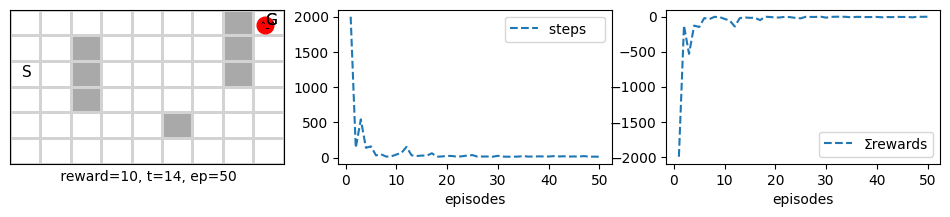

In [22]:
nbatch = 16
nnqlearn = DQN(env=vmaze(reward='reward10'), \
                episodes=50, \
                is_final_layer_zero=True, create_qNn=True,\
                α=7*1e-1, ε=0.2, dε=.999, εmin=0.1, γ=.97, \
                h1=0, h2=0, nF=16*4, \
                nbuffer=nbatch, nbatch=nbatch, endbatch=nbatch,\
                t_Qn=16, \
                self_path='DQN_exp',
                seed=1, **demoGame()).interact()

In [23]:
nnqlearn.ε

0.1

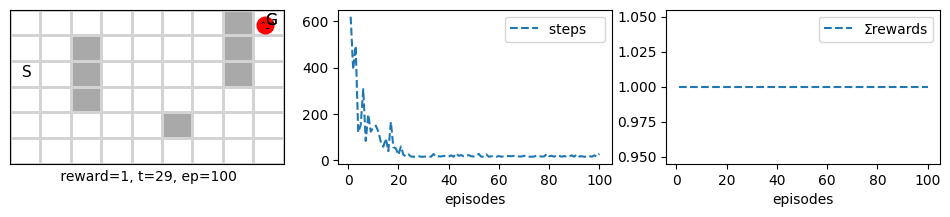

In [2]:
vqlearn = Qlearn(env=vmaze(), α=7*1e-1, ε=0.1, dε=1, εmin=0.05, γ=.93, episodes=100, seed=1, **demoGame()).interact()

False

# Worksheet 17: RL on Robotics

**Learning outcomes**
1. understand how to create a simple Robot environment that links to Gazebo
1. understand how to deal with the simulated environment in a grid world fashion
1. appreciate the intricacy of applying RL to the robotics domain
1. build on previous concepts to come up with a suitable solution to a problem at hand
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence
1. understand how to combine deep reinforcement learning with deep learning to create a powerful framework that allows automatic agent learning by observation or self-play.
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence for difficult problems that involve image processing and reinforcement learning


In this worksheet, we deal with how to set up a robot environment class that can handle the publish-subscribe on topics and deal with services in ROS. We must have ROS and Gazebo installed and set up on our machine. The code is a starting point and is not fully developed. You will need to write the necessary functionality to address a specific requirement. The main idea of tackling robotics applications in a Jupyter notebook is to utilise the provided infrastructure and libraries of code we covered in earlier units.

## Instructions for running Experiments on Azure VM
The VM usage limit is set to 120 hours. Please turn off the machine when not using it to preserve your time. The VM is not set to disconnect you automatically so that you can leave it training the robot continuously for assessment 2.

Please turn off the screen save and screen lock in Xfce(Applications->Settings->Light Locker) as it may cause the machine to become not responsive, which in turn, causes Azure to stop it automatically.

If the VM becomes corrupted for some reason, then you can reimage it by going to Azure Lab page and selecting the three dots, then reimage. *Reimage will reset the VM to its initial settings but it causes all data you have on the machine to be lost.* You are advised to backup your data, you may want to use OneDrive or other backup methods.

If Gazebo stops for any reason, the provided code has a `try-except` statement (in the base MRP class) that you can activate (comment in). It allows you to continue training even if the robot becomes not responsive without having to restart the experiment. But you will need to restart the kernel if you change the undrlying library. 

You can restart your notebook kernel when you want to re-establish a connection with the environment. However, this is rarely needed and even if gazebo stopped, you can still relaunch usng the above command and just rerun the latest cell wihout having to restart the kernel (let alone Clear All).

If you are running out of time, please let your tutor know in advance and they will try to increase your VM time allowance.


### Using your own VM
You *might* need to do `export PATH="home/rl/.local/bin:/opt/ros/foxy/share:$PATH` if you are using your own independent VM.

Go to /opt/ros/foxy/share/turtlebot3_gazebo/models/turtlebot3_burger/model.sdf and adjust the <update_rate>30</update_rate> to <update_rate>5</update_rate> for the odomotry turtlebot3_diff_drive. This will change its frequency from 30 to 5 so that it aligns with the scanner frequency.

Install [turtlebot3](https://emanual.robotis.com/docs/en/platform/turtlebot3/quick-start/#install-dependent-ros-packages-1) packages. If you are in our VM, the packages are already installed and no need to do anything.

## Launching the Gazebo Environment with TurtleBot Spawned
To launch a Gazebo environment with TurtleBot3, open a terminal and run the following command:

- `ros2 launch turtlebot3_gazebo turtlebot3_house.launch`
- `ros2 launch turtlebot3_gazebo turtlebot3_simple.launch.py`
- `ros2 launch turtlebot3_gazebo turtlebot3_assessment2.launch.py`

To make the testing smoother, you can right-click Gazebo and keep the window on top.
You can also press ctrl+R to reset the environment.

Note that you cannot do that inside the notebook because that the command blocks the notebook from executing other code. 

In [ ]:
%matplotlib inline

## The RobEnv Class (Interfacing Gazebo with RL Lib)

We have set up an environment called `RobEnv` (inside env.robot.py) that allows us to use the algorithms we developed in earlier units directly.

So long as the /scan(LaserScan), /odom (Odometry) and /cmd_vel(Twist) topics are available (due to launching a gazebo sim with an env and robot spawned), the environment should work fine. 

In [ ]:
from env.robot import *

### Summary of the RobEnv Class

-`RobEnv`: A ROS2 node that connects a TurtleBot robot with a Gazebo simulation. It manages robot control, sensor readings, and interactions within the environment.

-`odom`: Processes odometry data, updating the robot's position (`x, y`) and orientation (`θ`).  
-`scan`: Reads laser scan data, replacing infinite values with the maximum sensor range.  
-`yaw`: Converts quaternion orientation into a yaw angle in radians.  

-`θgoal`: Computes the angular distance between the robot and a goal.  
-`distgoal`: Calculates the Euclidean distance to the closest goal.  
-`atgoal`: Checks if the robot has reached a goal.  
-`atwall`: Detects potential collisions based on laser scan data.  

-`reward`: Assigns a reward based on the robot's state and action. It encourages movement towards goals and penalises collisions or undesired actions. If the robot collides with a wall, it automatically resets the environment.  

-`s_`: Converts the robot’s real-world position and orientation into a discrete state representation, mapping it to a grid system.  

-`spin_n`: Ensures the node updates by calling `ros.spin_once` multiple times.  
-`control`: Publishes movement commands.  
-`step`: Executes a specified action (`forward, turn left, turn right`), computes the next state, and returns a reward.  
-`stop`: Halts all movement.  

-`reset`: Restarts the simulation, ensuring a fresh environment for new episodes.  

This class is particularly useful for reinforcement learning applications, allowing the TurtleBot to learn navigation behaviours by interacting with a simulated Gazebo environment.  



**You can override any of the functions by inheriting the class**

## Setting the #laser scans for the LiDAR Sensors

We have provided you with a code to adjust the number of LiDAR beams in the model.sdf file directly in your jupyter notebook.

**Important**: if you changed the number of LiDARs then you will need to relaunch the environmnet for the canhes to take effect, otherwise you will get an error when you run the RL algorithms.

In [ ]:
# set_nscans_LiDAR(nscans=64)
accelerate_sim(speed=10)

Now we can launch the gazebo environment either 

1. programmatically using load_gazebo() which means that gazebo will terminate if you interrupted your code for any reason
2. or by executing `ros2 launch turtlebot3_gazebo turtlebot3_assessment2.launch.py` in a terminal

To ensure that all gazebo process are terminated, execute the following command. This is useful when your environment is stuck with `world client service...` message.

In [ ]:
kill_sim_processes()

Then relaunch

In [ ]:
# load_gazebo() # this not recommended do it from the terminal by executing the line below
# ros2 launch turtlebot3_gazebo turtlebot3_world.launch.py

### Connecting Gazebo with this Notebook
To establish the connection between gazebo and this notebook, we ned to run the fllowing command **once**

In [ ]:
ros.init()

### Moving the robot(Actions)
We can now start controlling the robot. Let us look at simple examples.

In [ ]:
env = RobEnv()

In [ ]:
env.step()

As we can see, the turtlebot robot moved forward in gazebo sim which proved that our interface class is working well.

## Rotational and Translational Calibration

Let us calibrate the rotational and translational movements of our robot settings. The idea here is to be able to get a consistent behaviour where a robot can consistently complete a full circle in a specified number of times *most of the times*. This is a trial and error process, we usually need to experiment with different settings, bearing in minde the accuracy and efficiency of the robot training that will take place later.

The frequency plays an important role as it specifies how many times the velocity changes commands are going to be executed per seconds. This is via our subscription to the /cmd_vel topic and the create_timer() function of the Node class.
The second important factor is the number of times the spin_once() is going to be executed. Spining a few times after publishing a command helps stablise the behaviour and gives us more consistency because it helps flush any delayed execution as well as any delayed subscription due to the robot hardware limitation which is simulated to an extent in Gazebo.

### Rotation in place to form a full $2\pi$ circle
You could try to increase the θspeed but that will result in more slippage.
It is also possible to increase the speed of execution (rather that the speed of the robot) by playing with n which is the number of times a spin_once() is executed. You could also speed up the clock by increasing the hz (frequency) of execution.

In [ ]:
θspeed = pi/3.5
speed = 2.0
n = 6

env = RobEnv(speed=speed, θspeed=θspeed, n=n, verbose=True)

In [ ]:
def rotate_test(env):
    env.reset()
    for _ in range(16):
        env.step(0)

# %time rotate_test(env)

Note that each time you run the above code, the robot's final position may vary slightly due to factors such as friction and other physical world influences.

### Translation calibration, moving in a straight line
You could try to increase the speed but that will result in bending.

In [ ]:
def forward_test(env):
    env.reset()
    for _ in range(10):
        env.step()

# forward_test(env)

### Manual solution (policy) to the given problem

In [ ]:
def optimal_policy1(env):
    env.reset( )
    for _ in range(2): env.step(0)
    for _ in range(8): env.step()
    
# %time optimal_policy1(env)

# Applying an RL Algorithms to Train a Turtlebot3 to Autonomously Reach the Goals

## Vectorised Environment
Let us now try to changed teh states from a number/index into vector.
We will simply utilise the laser scans. We can use them as is or try to turn them into some form of a hot encoding or tile coding. Below we show a simple implementaiton which you can build on. Note that we will import algorithms from RLv instead of RL so that we can use the vectorised linear model RL algorithms such Sarsa and Q_learning.

In [ ]:
# comment out the line below once you installed torch
!pip install torch

In [ ]:
from rl.rlln import *

In [ ]:
class vRobEnv(RobEnv):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.nF = len(self.scans)
        print('state size(laser beams)=', self.nF)

    # overridding reward_, 
    # you may use goal_dist, Δgoal_dist, θgoal_dist, Δθgoal_dist or at_wall and at_goal
    def reward_(self, a):
        # reward = sum([-self.Δgoal_dist*(a==1), .1*(a==1), .1*(a!=1),-self.Δθgoal_dist*(a!=1)/pi, -2*self.at_wall, 5*self.at_goal])
        # reward = sum([-1, -1*(a != 1)*(not self.at_goal), 1*self.at_goal])/3  #-1*self.at_wall,
        reward = sum([-1, 10*self.at_goal])
        if self.verbose and reward>-1: print('reward =', reward)#; print(f'action = {a}')
        return reward
    
    # overriding state representation, you may only use the laser self.scans
    def s_(self):
        max, min = self.max_range, self.min_range
        # returns a normalise and descritised componenets
        return  1*(((self.scans - min)/(max - min))>=.3)


In [ ]:
venv = vRobEnv(speed=speed, θspeed=θspeed, n=n,verbose=True) 

Now it is time to apply Sarsa on robotics! Note that this might not generate a useful policy yet. You must adjust the above code and tune your RL method hyperparameters.

In [ ]:
vqlearn = Qlearn(env=venv, α=1e-4, q0=0, ε=.0, \
                 max_t=1000, episodes=100, \
                 self_path='vQlearn_exp',\
                 seed=1, **demoGame())

In [ ]:
vqlearn.self_path

In [ ]:
# vqlearn.W[2]

### Resume Training and Extend training
If training interrupted for any reason (including finishing the assigned number of episodes), you can resume it by passing resume=True and rerun all the above cells. 

In [ ]:
resume = False

if resume:
    vqlearn = Qlearn.selfload(self_path='vQlearn_exp')
    vqlearn.env = venv
    vqlearn.episodes = 105 # extend sthe number of episodes

# saving the object after each episode for retrieval in case of a crash 
%time vqlearn.interact(resume=resume, save_ep=True) 

### To run without Training do the following

In [ ]:
# vqlearn.episodes = 200
# %time vqlearn.interact(resume=resume, train=False, save_ep=True) 

In [ ]:
# venv.reset()

## Nonlinear Function Approximation in Robotics

To handle nonlinear function approximation, we provide you with a powerful library, rl.rlnn, which includes a set of classes that can be readily utilised, including for implementing DQN. This library offers the essential infrastructure required to implement DQN, Double DQN, and other RL algorithms, should you need them.

In the following code, we use a fully connected neural network with Q-learning, specifically within the Deep Q-Network (DQN) framework. It is important to note that, despite the name, DQN does not necessarily require a deep architecture—especially when the input consists of simple laser scan data, which is far less complex than high-dimensional images typically handled by convolutional neural networks (CNNs).

The model architecture is configurable via the h1 and h2 parameters, which define the sizes of the hidden layers. Setting either (or both) to 0 simplifies the network structure. By default, the setup supports up to four layers, which is generally sufficient for the intended robotics applications.

If you wish to experiment with deeper architectures, you can modify the underlying model definition. However, for most cases with low-dimensional inputs, such as laser beams, additional depth is often unnecessary and may lead to overfitting or increased training complexity without significant benefits.

### Key Parameters

- `t_Qn`: Frequency (in steps) of updating the target network, used to stabilize learning alongside the main network.
- `save_weights`: Determines how often the model's weights are saved to disk, which is useful for resuming training after interruptions.
- `nbatch`: Size of the *mini-batch* sampled from the experience replay buffer for training.
- `nbuffer`: Minimum number of experiences required in the *replay buffer* before learning commences.
- `h1`: Size of the first hidden layer (set to `0` for no hidden layer).
- `h2`: Size of the second hidden layer (also settable to `0` if not needed).




You might consider enhancing the complexity of the environment's state representation to better match the expressive capacity of the neural network, particularly when using a Deep Q-Network (DQN) framework. A more detailed or structured input can help the model leverage the network's architecture more effectively, leading to better learning outcomes and more robust policy development.

For instance, increasing the resolution or range of the laser scan input can align more closely with the neural network’s ability to process and learn from richer data. While a small number of beams may suffice for basic reactive behaviors, expanding the laser scan to include a denser or wider set of measurements provides more spatial context, allowing the model to learn more nuanced and sophisticated policies.

This adjustment should remain computationally efficient and avoids the complexities of integrating visual data, which is not the focus in this case.


In [ ]:
from rl.rlnn import *

Below is a skeleton of the `nnRobEnv` class intended to be adapted for use with a non-linear function approximation model. Feel free to modify it as needed to suit your specific implementation, at the moment is uses the same reward and state of the `vRobEnv`.

In [ ]:
class nnRobEnv(vRobEnv):
    def __init__(self, **kw):
        super().__init__(**kw)
    
    # def reward_(self, a):
    #     return super().reward_(a)
    
    def reward_(self, a):
        reward = 10*self.at_goal # sparse reward
        if self.verbose and reward: print('reward =', reward)
        return reward
    
    def s_(self):
        return super().s_()


In [ ]:
nnenv = nnRobEnv(speed=speed, θspeed=θspeed, n=n, verbose=True)

In [ ]:
nnqlearn = DQN(env=nnenv, \
                episodes=100, \
                α=1e-4, ε=0.5, dε=.99, εmin=0.01, γ=.95, \
                h1=0, h2=0, nF=32, \
                nbuffer=5000, nbatch=32, endbatch=8,\
                t_Qn=100, \
                self_path='DQN_exp',
                seed=1, **demoGame())

In [ ]:
resume = False

if resume:
    nnqlearn = DQN.selfload(self_path='DQN_exp')
    nnqlearn.env = nnenv
    nnqlearn.episodes = 310 # change episodes as needed

# saving the object after each episode for retrieval in case of a crash 
%time nnqlearn.interact(resume=resume, save_ep=True)

## Loading an Algorithm Object after a Crash
If the whole VM stopped for any reasons, and you have lost your local variables in the Jupyter notebook, then you can resume, by loading the latest saved object.

To see how, you can Restart the kernel in the notebook which will delete all variable and imported libraries, then you can set resume = True and run all previous cells.

In [ ]:
for layer in nnqlearn.qN.layers:
    print(layer.weight)
    # print(layer.bias)


### Measuring Success Rate

If you have accelerated the simulation speed in Gazebo using set_real_time_rate, make sure to restore both the real-time rate and step size to a more standard values before measuring success rate.

In [ ]:
accelerate_sim(1) # back to normal
kill_sim_processes() # need to reload the sim for the change to take effect

In [ ]:
nnqlearn.episodes = 300
%time nnqlearn.interact(resume=True, train=False, save_ep=False) 

## Training Headless
To train more efficiently, you can disable the GUI in Gazebo. To do this, locate the .launch file that you use to launch Gazebo and comment out the following lines:

       IncludeLaunchDescription(
           PythonLaunchDescriptionSource(
               os.path.join(pkg_gazebo_ros, 'launch', 'gzclient.launch.py')
           ),
       ),

However, be aware that turning off the GUI may cause the robot to become unstable due to factors like wall collisions or lag. Without the visual feedback, it can be challenging to monitor the robot’s behaviour. If this happens and you need to see the robot’s state, you can press Ctrl + R to reset the simulation.

### Conclusion
In this worksheet, we have covered using RobEnv class and . We saw how to establish a connection between our notebook and the Gazebo simulated environment to control and train a robot inside it via one of our RL algorithms that we estbalished in earlier units.